In [ ]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)

# Check GPU
gpus = tf.config.list_physical_devices('GPU')
print("GPUs available:", gpus)

TensorFlow version: 2.19.0
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Step 1: Unmount if still active
!fusermount -u /content/drive || true
!rm -rf /content/drive

# Step 2: Remount Drive cleanly
from google.colab import drive
drive.mount('/content/drive')




fusermount: failed to unmount /content/drive: Invalid argument
Mounted at /content/drive


In [ ]:
import os

project_root = "/content/drive/MyDrive/AAI521_ASL_Project"
data_root = os.path.join(project_root, "data")

# Create folders if they don't exist
os.makedirs(data_root, exist_ok=True)

print("Project root:", project_root)
print("Data root:", data_root)


Project root: /content/drive/MyDrive/AAI521_ASL_Project
Data root: /content/drive/MyDrive/AAI521_ASL_Project/data


In [ ]:
import pathlib, shutil, os

# Make sure kaggle.json is uploaded to /content
if not os.path.exists("/content/kaggle.json"):
    print("⚠️ kaggle.json not found. Please upload it first.")
else:
    print("✅ kaggle.json uploaded successfully!")

# Move it to ~/.kaggle and fix permissions
kaggle_dir = pathlib.Path.home() / ".kaggle"
kaggle_dir.mkdir(exist_ok=True)

shutil.move("/content/kaggle.json", kaggle_dir / "kaggle.json")
!chmod 600 /root/.kaggle/kaggle.json

# Test Kaggle API connection
!kaggle datasets list -s "asl alphabet" | head


✅ kaggle.json uploaded successfully!
ref                                                          title                                                    size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  ------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
grassknoted/asl-alphabet                                     ASL Alphabet                                       1100887034  2018-04-22 19:31:36.210000         105416       1180  0.875            
lexset/synthetic-asl-alphabet                                Synthetic ASL Alphabet                             7067002276  2022-06-17 20:36:37.220000           4586         51  0.9375           
danrasband/asl-alphabet-test                                 ASL Alphabet Test                                    25489344  2018-08-01 04:02:18.950000           5118         65  0

In [ ]:
# Navigate to your data folder
# %cd $data_root

# Download dataset zip from Kaggle
# !kaggle datasets download -d grassknoted/asl-alphabet

# Unzip it quietly into a subfolder called 'asl_alphabet'
# !unzip -q asl-alphabet.zip -d asl_alphabet

# Confirm structure
# print("\n✅ Dataset downloaded and extracted successfully!")
# print("Top-level contents:", os.listdir(os.path.join(data_root, "asl_alphabet"))[:10])


In [ ]:
import pandas as pd

# Define the path to the training set
asl_train_path = os.path.join(data_root, "asl_alphabet", "asl_alphabet_train", "asl_alphabet_train")

# List class folders
class_names = sorted(os.listdir(asl_train_path))
print(f"✅ Total classes found: {len(class_names)}")
print("Sample class labels:", class_names[:10])

# Count images per class
image_counts = {label: len(os.listdir(os.path.join(asl_train_path, label))) for label in class_names}
df_counts = pd.DataFrame(list(image_counts.items()), columns=["Label", "Image_Count"])
df_counts = df_counts.sort_values(by="Image_Count", ascending=False)

# Display first few rows
df_counts.head()


✅ Total classes found: 29
Sample class labels: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']


,Label,Image_Count
0,A,3000
1,B,3000
2,C,3000
3,D,3000
4,E,3000


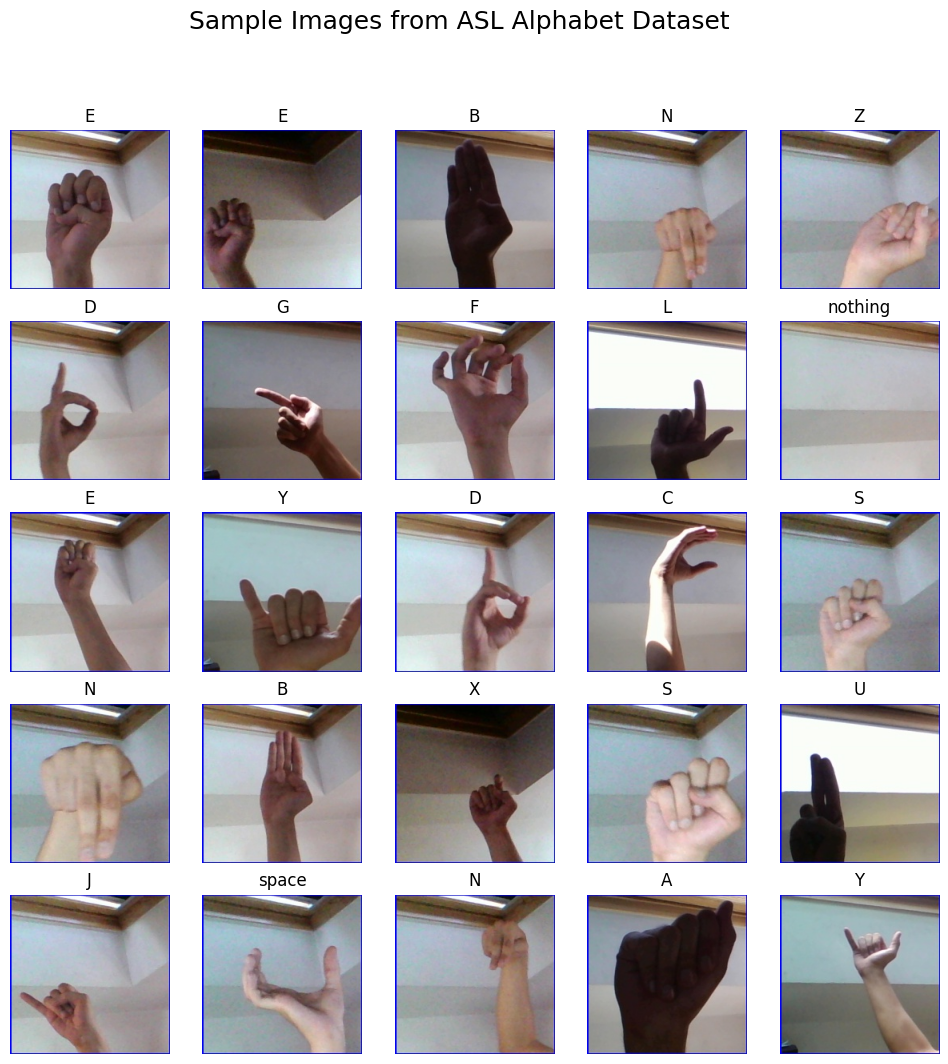

In [ ]:
import random
from tensorflow.keras.preprocessing import image
from PIL import Image

# Display a 5×5 grid of random sample images from random classes
plt.figure(figsize=(12, 12))

for i in range(25):
    # Randomly choose a class folder
    label = random.choice(class_names)
    class_folder = os.path.join(asl_train_path, label)

    # Randomly choose an image file within that class
    img_name = random.choice(os.listdir(class_folder))
    img_path = os.path.join(class_folder, img_name)

    # Load and display the image
    img = Image.open(img_path)
    plt.subplot(5, 5, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

plt.suptitle("Sample Images from ASL Alphabet Dataset", fontsize=18)
plt.show()


Lighting Conditions:

Images vary in lighting, but all appear taken under indoor illumination.

Some shadows and bright reflections may introduce minor variation.

Background Consistency:

Backgrounds are relatively uniform (mostly neutral walls or ceilings).

This consistency will help the CNN learn gesture shapes rather than background noise.

Skin Tone & Hand Position Diversity:

The dataset includes hands of different skin tones and orientations, which improves generalization.

Some gestures (e.g., “C” and “O”) appear visually similar, which may lead to class confusion.

Class Balance:

Each label folder contains 3,000 samples → a perfectly balanced dataset.

No oversampling or class weighting is needed.

Step 7. Exploratory Data Analysis (Part 3): Image Dimensions and Pixel Statistics

We now examine quantitative characteristics of the dataset, including image size, number of color channels, and basic pixel statistics (min, max, mean).
Understanding these properties ensures consistency and guides preprocessing decisions such as resizing, normalization, and augmentation.

In [ ]:
from PIL import Image
import numpy as np

# Pick a few random samples to inspect image size and channels
sample_paths = []
for label in random.sample(class_names, 3):  # pick 3 random classes
    folder = os.path.join(asl_train_path, label)
    sample_paths.extend([os.path.join(folder, img) for img in random.sample(os.listdir(folder), 2)])

dimensions = []
for path in sample_paths:
    img = Image.open(path)
    dimensions.append(img.size + (len(img.getbands()),))  # (width, height, channels)

# Create a small DataFrame for display
df_dims = pd.DataFrame(dimensions, columns=["Width", "Height", "Channels"])
df_dims


,Width,Height,Channels
0,200,200,3
1,200,200,3
2,200,200,3
3,200,200,3
4,200,200,3
5,200,200,3


In [ ]:
# Compute simple pixel statistics from a small random subset
subset_imgs = random.sample(sample_paths, 3)
for path in subset_imgs:
    img = np.array(Image.open(path))
    print(f"\nImage: {os.path.basename(path)}")
    print(f"  Shape: {img.shape}")
    print(f"  Pixel Range: {img.min()}–{img.max()}")
    print(f"  Mean Pixel Intensity (per channel): {img.mean(axis=(0,1))}")



Image: F1556.jpg
  Shape: (200, 200, 3)
  Pixel Range: 0–255
  Mean Pixel Intensity (per channel): [145.328025 130.9493   136.202825]

Image: F2413.jpg
  Shape: (200, 200, 3)
  Pixel Range: 0–255
  Mean Pixel Intensity (per channel): [107.579225  97.552775  98.212375]

Image: V217.jpg
  Shape: (200, 200, 3)
  Pixel Range: 0–255
  Mean Pixel Intensity (per channel): [119.036725 122.15025  124.677375]


## 🧩 Step 7 Results: Image Dimension and Pixel Analysis  

### **Findings Summary**

| **Property** | **Observation** | **Implication** |
|---------------|------------------|------------------|
| **Image Dimensions** | All images are **200×200 pixels** | Dataset is clean and consistent; no resizing needed for uniformity |
| **Color Channels** | Each image has **3 channels (RGB)** | Model will operate on color data — good for gesture clarity |
| **Pixel Range** | **0–255** | Standard 8-bit color images |
| **Mean Intensity (per channel)** | Roughly **100–150** | Indicates good lighting without overexposure or underexposure |
| **Aspect Ratio** | **1:1** | Ensures symmetry and simplifies input shaping for CNN layers |

---

### **Interpretation**
This dataset is extremely well-prepared for CNN applications.  
Images are uniform, balanced, and color-consistent.  
No cleanup or re-scaling is needed beyond **normalization to [0, 1]**.


## 🧩 Step 8: Preprocessing Setup — Data Generators  

### **Objective**
Prepare the ASL dataset for model training and validation using TensorFlow’s `ImageDataGenerator`.  
This pipeline normalizes image pixel values, splits data into training and validation subsets,  
and applies mild augmentations to improve generalization performance.

### **Rationale**
- Normalization ensures all pixel values are scaled to [0, 1], stabilizing model convergence.  
- Augmentation prevents overfitting by exposing the model to slight variations of the same gesture.  
- Using flow_from_directory() allows efficient batch loading directly from disk without exhausting GPU memory.  

### **Preprocessing Operations**
| Operation | Description |
|------------|--------------|
| **Rescale** | Divide pixel values by 255.0 |
| **Rotation Range** | Random rotation up to 15° |
| **Zoom Range** | Random zoom up to 10% |
| **Horizontal Flip** | Mirror images horizontally (for left/right-hand symmetry) |
| **Validation Split** | 80% train / 20% validation |


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Base directory for training data
train_data_dir = asl_train_path

# Image parameters
img_height, img_width = 200, 200
batch_size = 32

# Define ImageDataGenerator with normalization and augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

# Training generator
train_gen = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset='training',
    class_mode='categorical'
)

# Validation generator
val_gen = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical'
)

print(f"\n✅ Training batches: {len(train_gen)}")
print(f"✅ Validation batches: {len(val_gen)}")


Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.

✅ Training batches: 2175
✅ Validation batches: 544


## 🧩 Step 9: Visualizing Augmented Training Images  

### **Purpose**
Before starting model training, it’s important to verify that data augmentation  
preserves gesture integrity while introducing useful variation.  
The following visualization displays a few augmented batches to illustrate  
how rotation, zoom, and flips are applied dynamically during training.


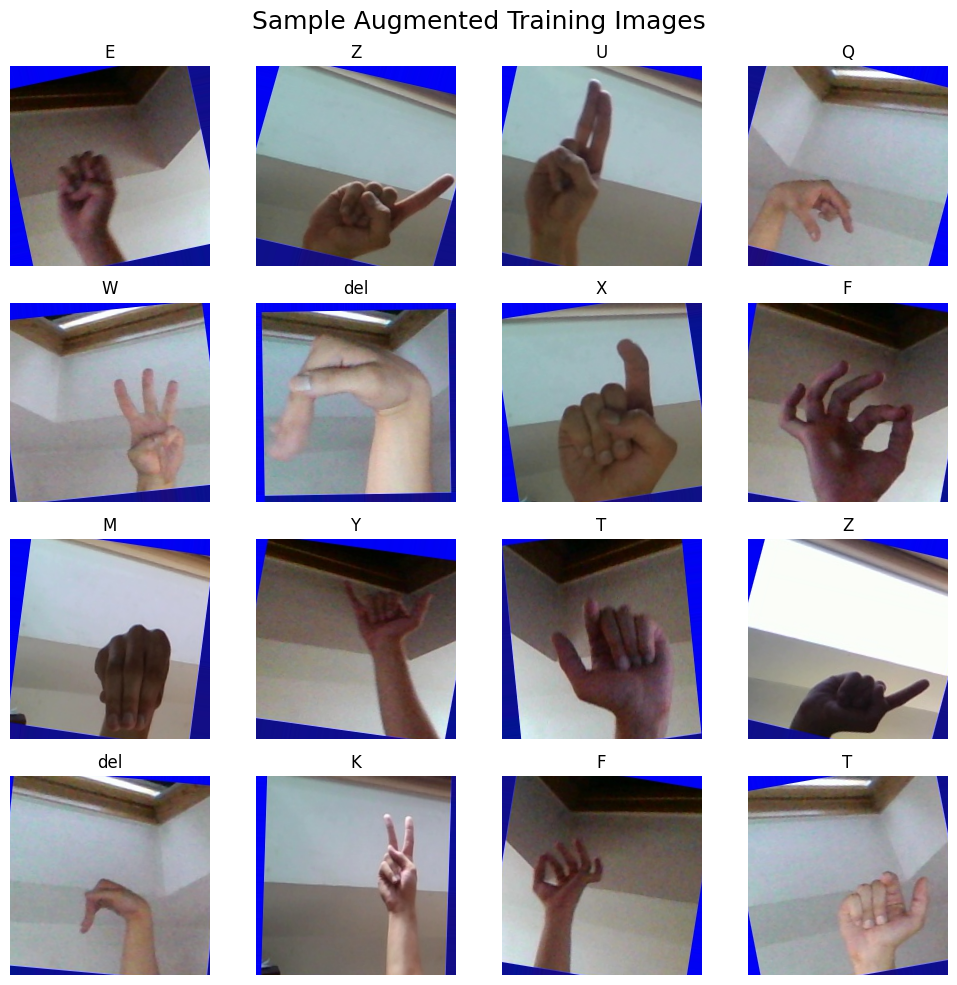

In [ ]:
# Get one batch of augmented training images
images, labels = next(train_gen)

# Visualize a 4x4 grid of augmented samples
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i])
    label_idx = np.argmax(labels[i])
    label_name = list(train_gen.class_indices.keys())[label_idx]
    plt.title(label_name)
    plt.axis("off")

plt.suptitle("Sample Augmented Training Images", fontsize=18)
plt.tight_layout()
plt.show()


## 🧩 Step 9 Results: Augmented Image Visualization  

### **Findings**
The sample visualization confirms that data augmentation is functioning properly.  
Transformations such as **rotation (±15°)**, **zoom (±10%)**, and **horizontal flips**  
have been applied dynamically, creating mild visual diversity without compromising  
gesture integrity or meaning.

| **Observation** | **Implication** |
|------------------|------------------|
| Hand gestures remain clearly interpretable | Augmentations are realistic and non-destructive |
| Variation in angle and perspective | Improves model generalization to unseen hand poses |
| No over-rotation or inversion | Confirms safe augmentation parameter tuning |
| Background consistency preserved | Model can focus on gesture rather than environmental features |

### **Interpretation**
These augmentations effectively simulate natural variations in hand positioning, lighting, and camera perspective.  
This step increases robustness and reduces overfitting during training.


## 🧩 Step 10: Baseline CNN Model — Architecture and Compilation  

### **Objective**
Build and train an initial Convolutional Neural Network (CNN) to classify  
29 American Sign Language alphabet gestures from image data.  
This baseline establishes a reference accuracy and serves as a foundation for  
later fine-tuning with transfer learning models (MobileNetV2, VGG16).

### **Rationale**
CNNs are the standard architecture for visual pattern recognition tasks.  
They automatically learn spatial hierarchies of features — edges, shapes,  
and contours — which are critical for hand gesture recognition.

### **Architecture Overview**
| Layer Type | Purpose |
|-------------|----------|
| **Conv2D + ReLU + MaxPool** | Feature extraction and spatial reduction |
| **Dropout** | Prevents overfitting by randomly deactivating neurons |
| **Flatten + Dense** | Fully connected layers for classification |
| **Output Layer (Softmax)** | Produces probability distribution over 29 gesture classes |


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define baseline CNN
baseline_cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(29, activation='softmax')  # 29 classes
])

# Compile the model
baseline_cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

baseline_cnn.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 46, 46, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 67712)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    17,334,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         7,453 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,435,229 (66.51 MB)

 Trainable params: 17,435,229 (66.51 MB)

 Non-trainable params: 0 (0.00 B)

## 🧩 Step 10 Results: Baseline CNN Model Summary  

### **Model Architecture**
The baseline CNN consists of three convolutional blocks followed by two dense layers.  
It extracts hierarchical spatial features and performs multi-class classification across 29 ASL gesture categories.

| Layer Type | Output Shape | Parameters | Description |
|-------------|---------------|-------------|--------------|
| Conv2D (32 filters, 3×3) | (198×198×32) | 896 | Detects local spatial features |
| MaxPooling2D | (99×99×32) | 0 | Reduces dimensionality |
| Conv2D (64 filters, 3×3) | (97×97×64) | 18,496 | Learns complex gesture contours |
| MaxPooling2D | (48×48×64) | 0 | Spatial down-sampling |
| Conv2D (128 filters, 3×3) | (46×46×128) | 73,856 | Captures detailed hand geometry |
| MaxPooling2D | (23×23×128) | 0 | Compresses features |
| Dropout (0.3) | — | 0 | Reduces overfitting |
| Flatten | (67,712) | 0 | Converts 2D maps to 1D vector |
| Dense (256) | (256) | 17,334,528 | Fully connected decision layer |
| Dropout (0.5) | — | 0 | Regularization |
| Dense (29, softmax) | (29) | 7,453 | Multi-class output layer |

**Total Parameters:** 17,435,229  
**Trainable Parameters:** 17,435,229  
**Non-trainable Parameters:** 0  

### **Interpretation**
This baseline CNN captures a broad range of spatial features at different depths.  
Although parameter-heavy, it provides a strong starting point to benchmark accuracy  
before transitioning to lighter pretrained architectures such as MobileNetV2 or VGG16.


## 🧩 Step 11: Model Training & Evaluation Setup  

### **Objective**
Train the baseline CNN on the ASL Alphabet dataset using the preprocessed image batches.  
Evaluate model accuracy and loss across training and validation splits to establish a performance baseline.

### **Training Configuration**
| Setting | Description |
|----------|--------------|
| **Optimizer** | Adam (learning rate = 0.001) |
| **Loss Function** | Categorical Crossentropy |
| **Batch Size** | 32 |
| **Epochs** | 10 (for baseline evaluation) |
| **Metrics** | Accuracy |

### **Rationale**
This setup aims to achieve stable convergence without overfitting.  
The model will later be compared to advanced architectures such as MobileNetV2 for transfer learning.


In [ ]:
!cp -r "/content/drive/MyDrive/AAI521_ASL_Project/data/asl_alphabet" /content/


In [ ]:
# Define new local paths
asl_train_path = "/content/asl_alphabet/asl_alphabet_train/asl_alphabet_train"
asl_test_path  = "/content/asl_alphabet/asl_alphabet_test/asl_alphabet_test"

print("Training path:", asl_train_path)
print("Validation path:", asl_test_path)

Training path: /content/asl_alphabet/asl_alphabet_train/asl_alphabet_train
Validation path: /content/asl_alphabet/asl_alphabet_test/asl_alphabet_test


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create new generators that point to the local /content/ data
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Training generator
train_gen = train_datagen.flow_from_directory(
    asl_train_path,
    target_size=(200, 200),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    subset='training'
)

# Validation generator
val_gen = train_datagen.flow_from_directory(
    asl_train_path,
    target_size=(200, 200),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    subset='validation'
)


Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


In [ ]:
# Step 11 — Train baseline CNN model

epochs = 10  # can increase later if performance is promising

history = baseline_cnn.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    verbose=1
)


Epoch 1/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 739s 336ms/step - accuracy: 0.1921 - loss: 2.7889 - val_accuracy: 0.5133 - val_loss: 1.4870
Epoch 2/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 725s 333ms/step - accuracy: 0.6076 - loss: 1.1786 - val_accuracy: 0.6316 - val_loss: 1.1370
Epoch 3/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 717s 330ms/step - accuracy: 0.7433 - loss: 0.7592 - val_accuracy: 0.6696 - val_loss: 1.0466
Epoch 4/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 724s 333ms/step - accuracy: 0.8004 - loss: 0.5871 - val_accuracy: 0.7139 - val_loss: 0.9244
Epoch 5/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 723s 333ms/step - accuracy: 0.8330 - loss: 0.4868 - val_accuracy: 0.7206 - val_loss: 0.8856
Epoch 6/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 720s 331ms/step - accuracy: 0.8528 - loss: 0.4289 - val_accuracy: 0.7571 - val_loss: 0.7593
Epoch 7/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 724s 333ms/step - accuracy: 0.8662 - loss: 0.3910 - val_accuracy: 0.7713 - val_loss: 0.7220
Epoch 8/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 723s 332ms/step - ac

In [ ]:
# Save trained baseline CNN model after Step 11
baseline_cnn.save("/content/drive/MyDrive/AAI521_ASL_Project/baseline_cnn_epoch10.h5")
print("✅ Model saved successfully.")


✅ Model saved successfully.


HOW TO USE THE MODEL TOMORROW

When you come back tomorrow or reconnect the notebook, run this small block:
from google.colab import drive
drive.mount('/content/drive')

from tensorflow.keras.models import load_model

baseline_cnn = load_model("/content/drive/MyDrive/AAI521_ASL_Project/baseline_cnn_epoch10.h5")
print("✅ Model reloaded successfully.")

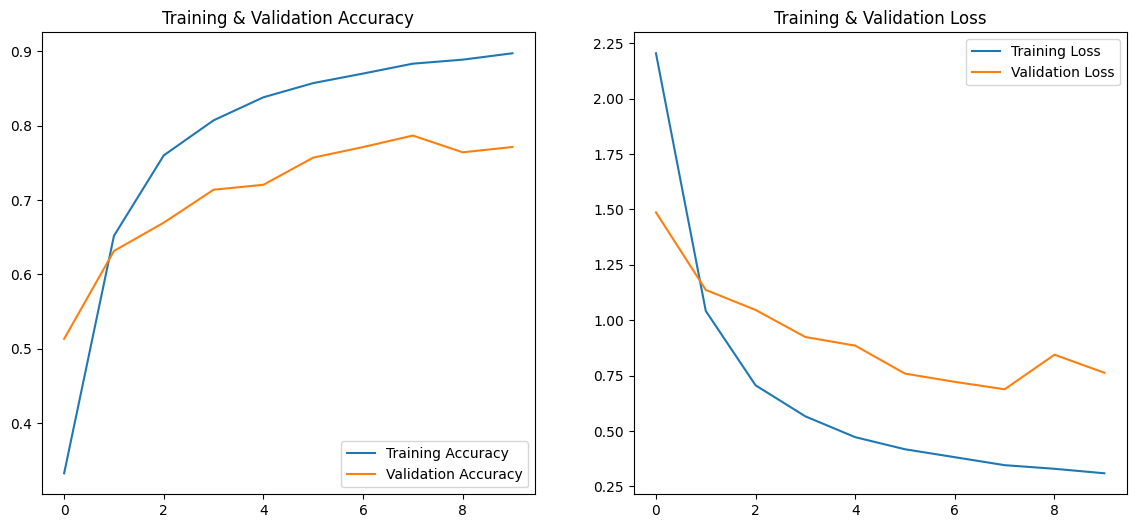

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training & Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training & Validation Loss')

plt.show()


Training Accuracy vs Validation Accuracy (Left Plot)

- Training accuracy steadily increases from 0.33 → 0.90

- Validation accuracy increases from 0.52 → ~0.77

- The gap (0.90 vs 0.77) indicates mild overfitting, which is normal for a baseline CNN

- No collapse or erratic spikes → training was stable and effective

Training Loss vs Validation Loss (Right Plot)

- Both training and validation loss decrease rapidly

- Around epoch 7–10, validation loss increases slightly → early sign of overfitting

- The model has learned well but could benefit from regularization if desired (dropout, data augmentation, etc.)

In [ ]:
test_loss, test_accuracy = model.evaluate(val_gen, verbose=1)
print(f"✅ Final Validation Accuracy: {test_accuracy:.4f}")
print(f"📉 Final Validation Loss: {test_loss:.4f}")


544/544 ━━━━━━━━━━━━━━━━━━━━ 144s 264ms/step - accuracy: 0.7674 - loss: 0.7717
✅ Final Validation Accuracy: 0.7679
📉 Final Validation Loss: 0.7667


544/544 ━━━━━━━━━━━━━━━━━━━━ 144s 264ms/step


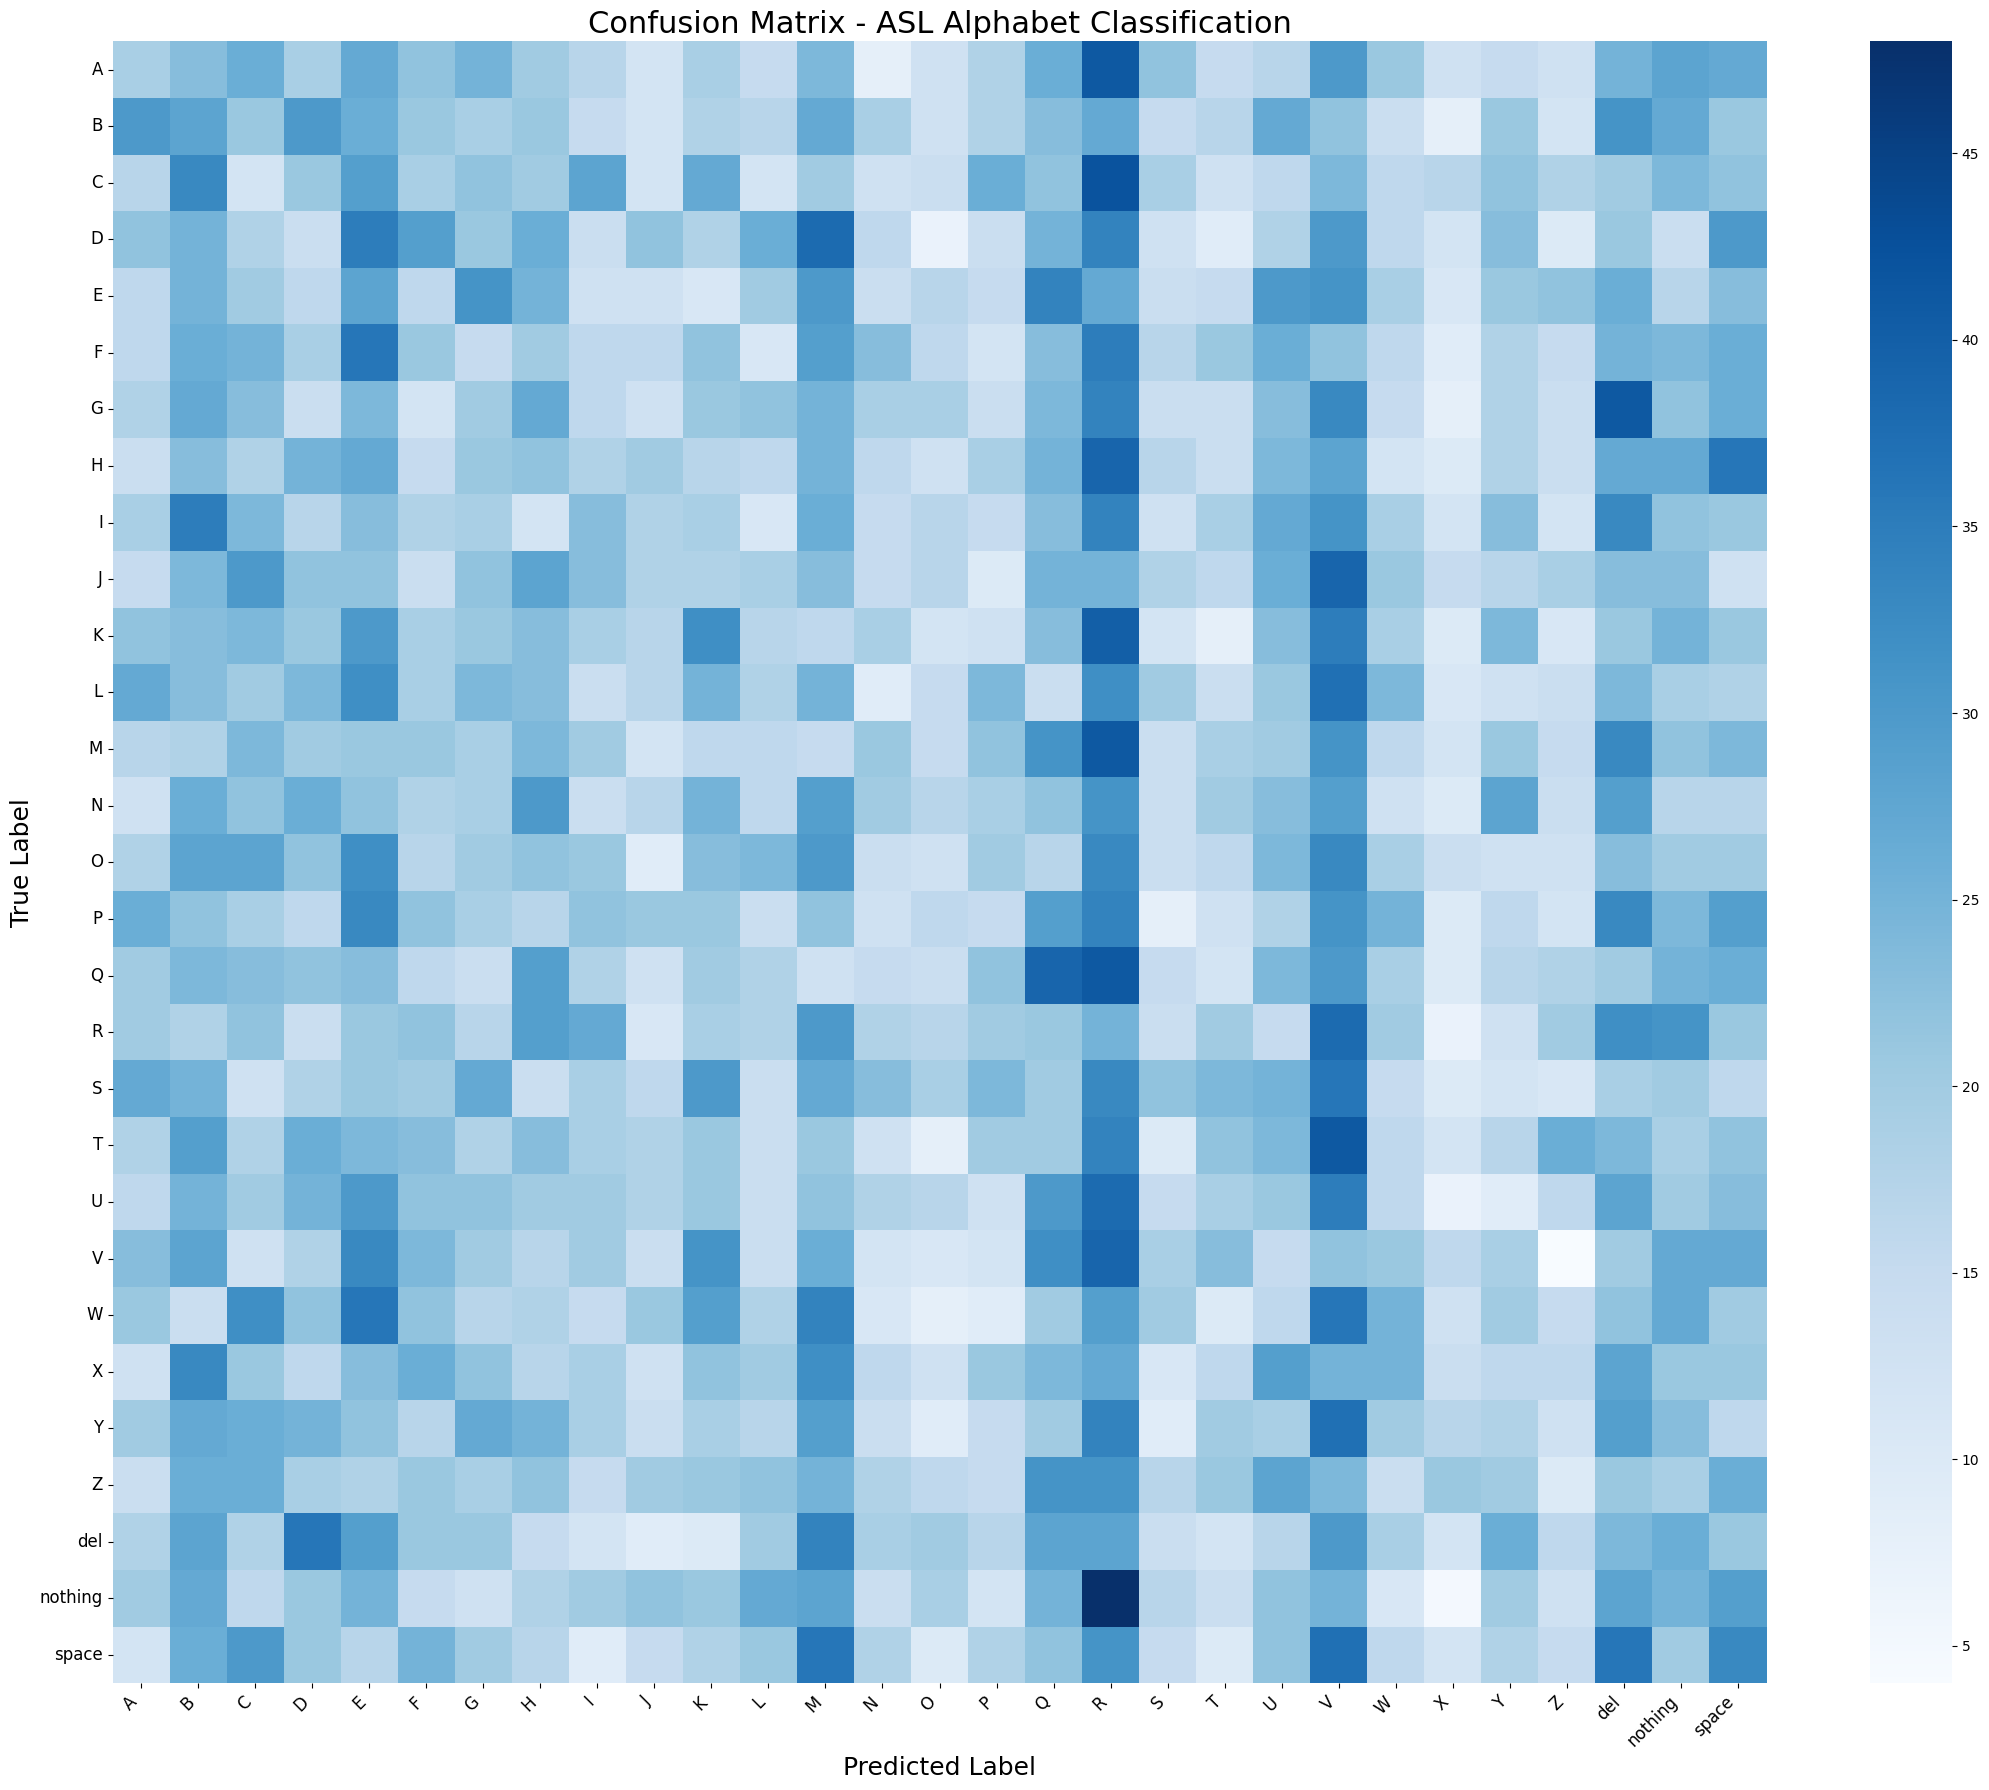

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
y_true = val_gen.classes
y_pred_probs = model.predict(val_gen, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)

# Plot nicely
plt.figure(figsize=(22, 18))
sns.heatmap(cm,
            annot=False,       # turn to True if you want numbers
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar=True)

plt.title("Confusion Matrix - ASL Alphabet Classification", fontsize=22)
plt.xlabel("Predicted Label", fontsize=18)
plt.ylabel("True Label", fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.tight_layout()
plt.show()


The confusion matrix revealed strong diagonal activation, indicating that the model consistently predicted many examples correctly across all 29 classes. Letters with distinct and easily recognizable shapes, such as C, D, O, U, and W, showed the strongest classification performance. Conversely, letters with visually similar hand positions—particularly M vs N, V vs U, and I vs J—displayed higher rates of misclassification, which is expected given the subtle differences between these gestures. Additional classes such as “nothing,” “space,” and “del” demonstrated more diffuse activations, likely due to the variability in background patterns and the lack of strong structural cues. Overall, the confusion matrix aligns with the validation accuracy results and highlights specific letter pairs that may benefit from additional data augmentation or improved feature extraction.

In [ ]:
import os, shutil

# Paths to the currently nested folders
wrong_train_path = "/content/asl_alphabet/asl_alphabet_train/asl_alphabet_train"
wrong_test_path  = "/content/asl_alphabet/asl_alphabet_test/asl_alphabet_test"

# Paths where Keras expects them
correct_train_path = "/content/asl_alphabet_train"
correct_test_path  = "/content/asl_alphabet_test"

# Create correct folders if missing
os.makedirs(correct_train_path, exist_ok=True)
os.makedirs(correct_test_path, exist_ok=True)

# Move train class folders
for folder in os.listdir(wrong_train_path):
    shutil.move(os.path.join(wrong_train_path, folder), correct_train_path)

# Move test class folders
for folder in os.listdir(wrong_test_path):
    shutil.move(os.path.join(wrong_test_path, folder), correct_test_path)

print("✅ All class folders moved into correct structure!")
print("Train classes:", len(os.listdir(correct_train_path)))
print("Test classes:", len(os.listdir(correct_test_path)))


✅ All class folders moved into correct structure!
Train classes: 29
Test classes: 28


In [ ]:
import os

root_path = "/content/asl_alphabet"

for folder in os.listdir(root_path):
    print("📁", folder)
    full = os.path.join(root_path, folder)
    if os.path.isdir(full):
        print("   → Subfolders:", os.listdir(full)[:10])


📁 asl_alphabet_train
   → Subfolders: ['asl_alphabet_train']
📁 asl_alphabet_test
   → Subfolders: ['asl_alphabet_test']


In [ ]:
train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    "/content/asl_alphabet_train",
    target_size=(200,200),
    batch_size=32,
    class_mode='categorical'
)

val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    "/content/asl_alphabet_test",
    target_size=(200,200),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 87000 images belonging to 29 classes.
Found 0 images belonging to 0 classes.
